# Illustrations for the Wavelet Model

In [16]:
# import relevant packages 
from src.data.preprocess_utils import bin_data
from scipy.signal import chirp, cwt, morlet
from scipy.fftpack import fft, fftfreq
from src.model.wavelet_model import * 
from matplotlib import pyplot as plt 
from scipy.signal import find_peaks
import seaborn as sns 
import numpy as np 
import pickle 
import pywt 

sns.set_theme()

rcParams = {
    "font.family": "serif",  # use serif/main font for text elements
    'text.usetex': True,
    'font.size': 8,
    'axes.labelsize': 7,
    'axes.titlesize': 9,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 7,
    'axes.labelpad': 1,
    'axes.axisbelow': True,  # draw gridlines below other elements
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    "pgf.preamble": "\n".join([
        r"\usepackage{url}",            # load additional packages
        r"\usepackage{amsmath,amssymb}",   # unicode math setup
        #  r"\setmainfont{DejaVu Serif}",  # serif font via preamble
    ])
}
plt.rcParams.update(rcParams)

figdir = "../../../figures/methods/"
def savefig(fig, name, width=6, height=4):
    # apply rcParams
    fig.set_size_inches(width, height)
    fig.savefig(figdir + name + ".pdf", bbox_inches='tight')



### Mother wavelet 

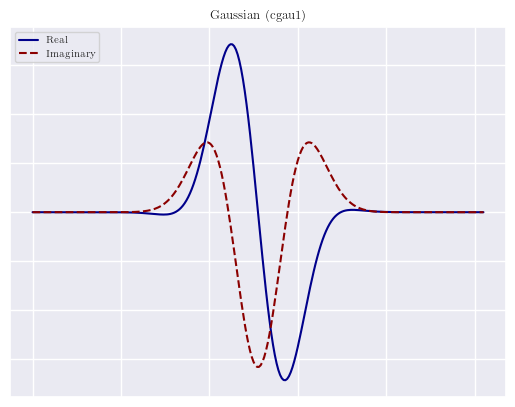

In [14]:
wavelet = pywt.ContinuousWavelet('cgau1')

fig, ax = plt.subplots(1, 1)
ax.plot(np.real(wavelet.wavefun()[0]), color = "darkblue", label = "Real")
ax.plot(np.imag(wavelet.wavefun()[0]), color = "darkred", linestyle = "--", label = "Imaginary")
ax.set_title("Gaussian (cgau1)")
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.legend(loc = "upper left")
plt.show()

savefig(fig, "cgau1_wavelet", width = 2.5, height = 1.56)

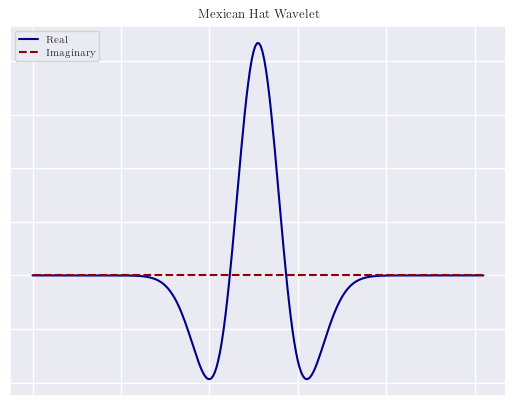

In [12]:
wavelet = pywt.ContinuousWavelet('mexh')

fig, ax = plt.subplots(1, 1)
ax.plot(np.real(wavelet.wavefun()[0]), color = "darkblue", label = "Real")
ax.plot(np.imag(wavelet.wavefun()[0]), color = "darkred", linestyle = "--", label = "Imaginary")
ax.set_title("Mexican Hat Wavelet")
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.legend(loc = "upper left")
plt.show()

savefig(fig, "mexican_hat", width = 2.5, height = 1.56)

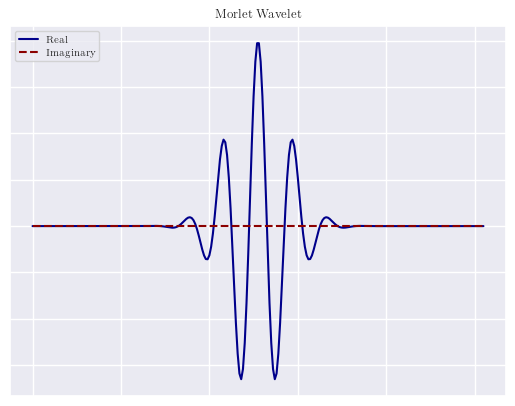

In [13]:
wavelet = pywt.ContinuousWavelet('morl')

fig, ax = plt.subplots(1, 1)
ax.plot(np.real(wavelet.wavefun()[0]), color = "darkblue", label = "Real")
ax.plot(np.imag(wavelet.wavefun()[0]), color = "darkred", linestyle = "--", label = "Imaginary")
ax.set_title("Morlet Wavelet")
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.legend(loc = "upper left")
plt.show()

savefig(fig, "mor", width = 2.5, height = 1.56)

### Wavelet Coefficients 

In [17]:
with open("simulated_data.pkl", 'rb') as f:
    file = pickle.load(f)
f.close()

channel = 1
bin_idx = 20 
peaks, _ = find_peaks(file['filt_signal'][:, channel], height = 30, distance = 2900)
bins = bin_data(file['filt_signal'][:, channel], peaks).T 
true_bins = bin_data(file['true_signal'][:, channel], peaks).T

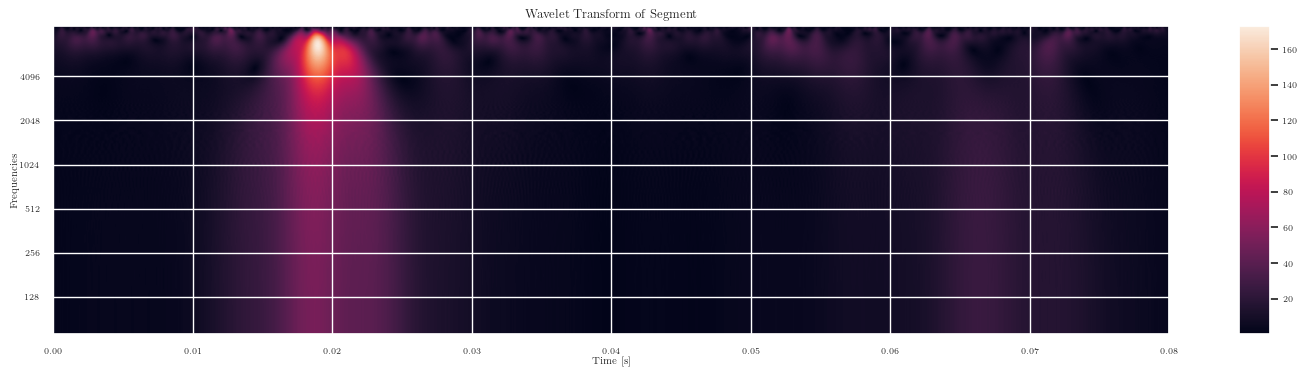

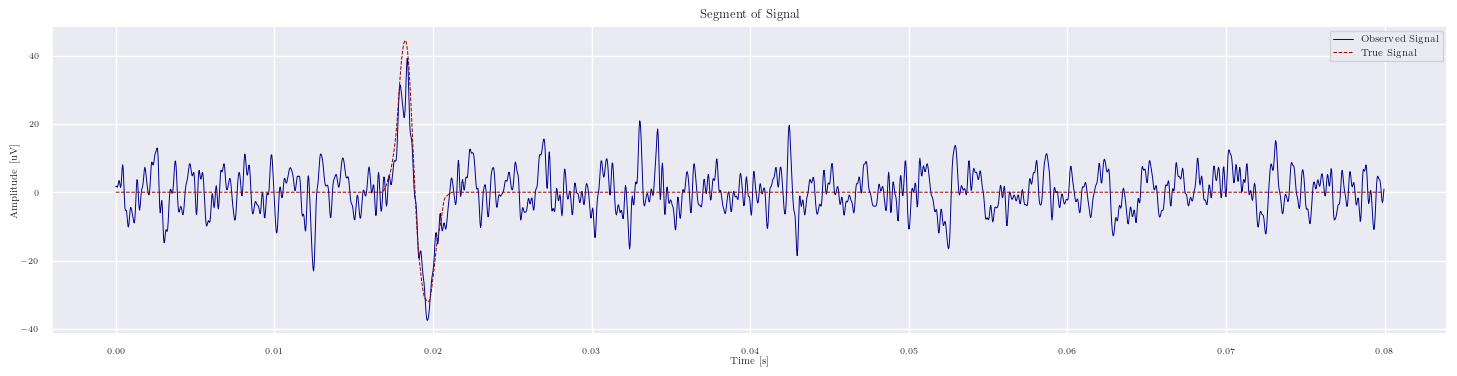

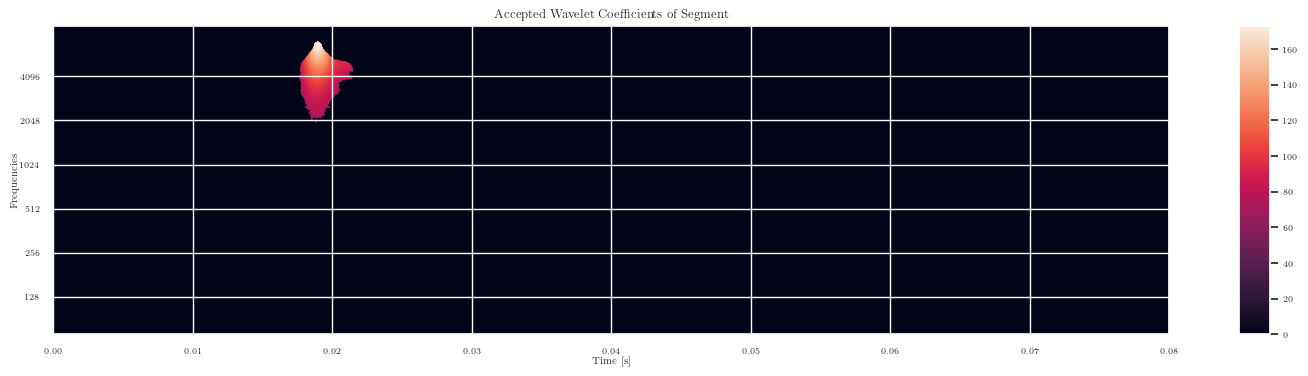

In [20]:
# apply wavelet transform
scales = np.arange(1, 128)
coefficients, frequencies = pywt.cwt(bins[:, bin_idx], scales=scales, wavelet='cgau1', sampling_period=1/30000)

fig = plt.figure(figsize = (18, 4))
plt.imshow(np.flipud(np.abs(coefficients)), extent=[0, len(bins) / 30000, frequencies.min(), frequencies.max()],
           aspect='auto', origin='lower')
plt.colorbar(aspect=10)
plt.yscale("log")
plt.yticks([128, 256, 512, 1024, 2048, 4096], ["128", "256", "512", "1024", "2048", "4096"])
plt.title("Wavelet Transform of Segment")
plt.ylabel("Frequencies")
plt.xlabel("Time [s]")
plt.show()

savefig(fig, "wavelet_coefficients", width = 6, height=1.5)

fig = plt.figure(figsize = (18, 4))
plt.plot(np.arange(2400) / 30000, bins[:, bin_idx], color = "darkblue", linewidth = 0.7)
plt.plot(np.arange(2400) / 30000, true_bins[:, bin_idx], '--', color = "darkred", linewidth = 0.7)
plt.title("Segment of Signal")
plt.ylabel("Amplitude [uV]")
plt.xlabel("Time [s]")
plt.legend(["Observed Signal", "True Signal"])
plt.show()

savefig(fig, "wavelet_time_segment", width = 6, height=1.5)

accepted_coefficients = get_accepted_coefficients(coefficients, scales, 0.5)

fig = plt.figure(figsize = (18, 4))
plt.imshow(np.flipud(np.abs(accepted_coefficients)), extent=[0, len(bins) / 30000, frequencies.min(), frequencies.max()],
           aspect='auto', origin='lower')
plt.colorbar(aspect = 10)
plt.title("Accepted Wavelet Coefficients of Segment")
plt.ylabel("Frequencies")
plt.yscale("log")
plt.yticks([128, 256, 512, 1024, 2048, 4096], ["128", "256", "512", "1024", "2048", "4096"])
plt.xlabel("Time [s]")
plt.show()

savefig(fig, "wavelet_coefficients_accepted", width = 6, height=1.5)



### Illustration of Different Mother Wavelets 

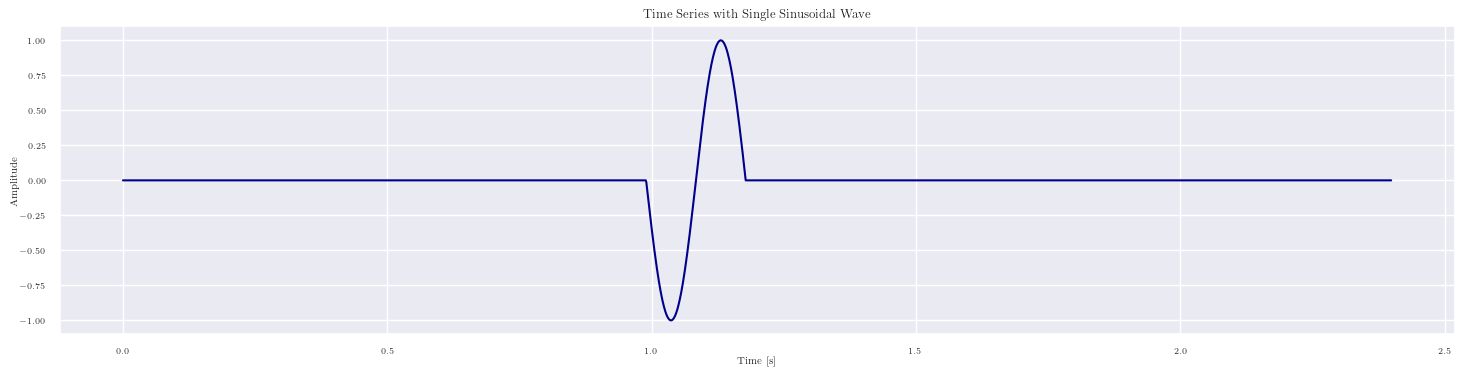

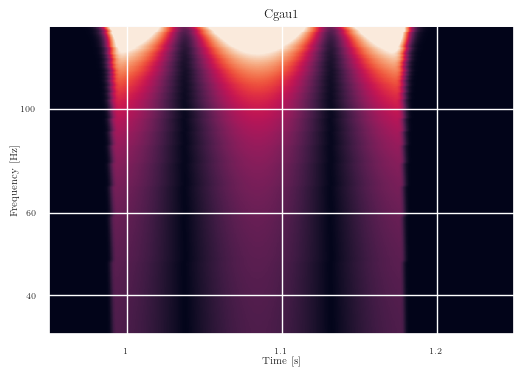

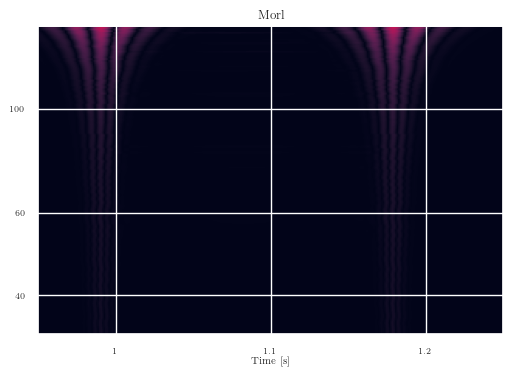

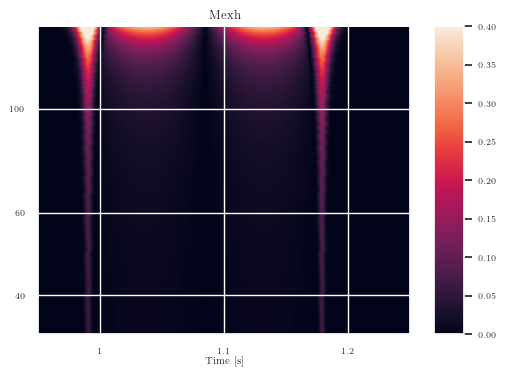

In [ ]:
from matplotlib.ticker import LogFormatter 


fs = 1000  # Sampling frequency (Hz)
t = np.arange(2400) / fs

# Create time series with a single-period sinusoidal wave
x = np.zeros(2400)
x[990:1178] = np.cos(1000/30 * t[990:1178])  # Insert 1 kHz sine wave


wavelets = ["cgau1", "morl", "mexh"]
savefig_names = ["wavelet_single_sinus_gaus", "wavelet_single_sinus_morl", "wavelet_single_sinus_mexh"]

# Plot original time series
fig = plt.figure(figsize=(18, 4))
plt.plot(t, x, color="darkblue")
plt.title("Time Series with Single Sinusoidal Wave")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()
savefig(fig, "wavelet_single_sinus", width=6.5, height=1.5)

# Loop over wavelets and generate scalograms
for wavelet, savefig_name in zip(wavelets, savefig_names):
    central_freq = pywt.central_frequency(wavelet)  # Get wavelet's characteristic frequency

    # Define scales based on desired frequency range
    frequencies = np.linspace(33, 150, 100)  # Focus on the range around 33.3 Hz
    scales = central_freq / (frequencies * (1 / fs))

    # Compute CWT
    coefs, freqs = pywt.cwt(x, scales, wavelet, sampling_period=1 / fs)

    # Plot scalogram
    fig = plt.figure(figsize=(6, 4))
    plt.imshow(np.flipud(np.abs(coefs)), extent=[0, len(x) / fs, frequencies.min(), frequencies.max()],
               aspect='auto', origin='lower', vmin = 0.0, vmax = 0.4) 
    
    # plt.yscale('log') 
    # plt.yticks([33, 67, 100], ["50", "67", "100"])
    plt.xlabel("Time [s]")
    plt.xlim([0.95, 1.25])  
    plt.xticks([1.0, 1.1, 1.2], ["1", "1.1", "1.2"])
    plt.title(wavelet.capitalize())

    plt.yscale("log")  
    plt.yticks([40, 60, 100], ["40", "60", "100"])  # Explicitly set labels
    plt.gca().yaxis.set_major_formatter(LogFormatter(labelOnlyBase=False, minor_thresholds=(np.inf, np.inf)))

    
    # add y-label for first plot only
    if wavelet == "cgau1":
        plt.ylabel("Frequency [Hz]")
    # Add colorbar for "mexh" wavelet only
    if wavelet == "mexh":
        plt.colorbar(aspect=10)

    plt.show()
    savefig(fig, savefig_name, width=1.7, height=1.2)


### Time vs Frequency vs Wavelet Domain 

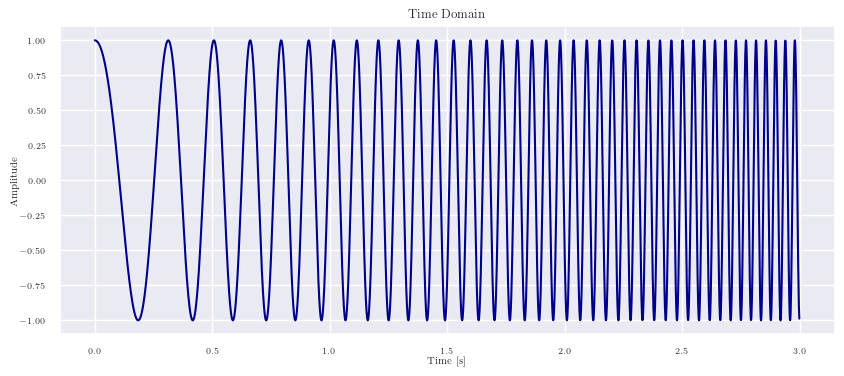

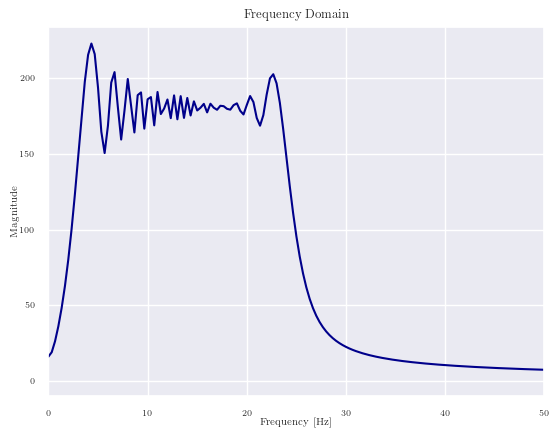

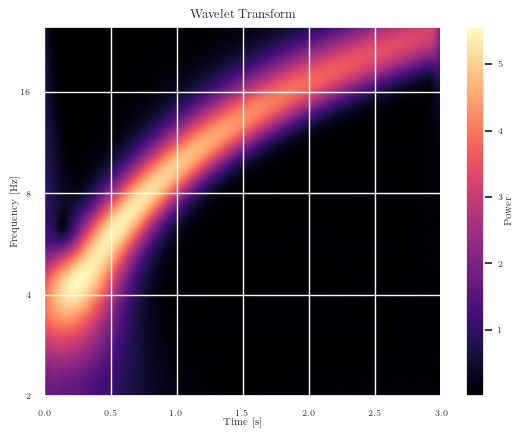

In [7]:
# Parameters
fs = 1000   # Sampling frequency (Hz)
T = 3       # Signal duration (seconds)
t = np.linspace(0, T, fs * T, endpoint=False)

# Generate a chirp signal (frequency increasing from 5 Hz to 50 Hz)
f_start, f_end = 2, 25  
signal = chirp(t, f0=f_start, f1=f_end, t1=T, method='linear')

# Compute Fourier Transform
N = len(t)
freqs = fftfreq(N, 1/fs)  # Frequency axis
fft_vals = np.abs(fft(signal))  # Magnitude of FFT

# Compute Scalogram using Continuous Wavelet Transform (CWT)
central_freq = pywt.central_frequency("cmor1.5-1.0")  # More precise wavelet
scales = central_freq / (np.linspace(f_start, f_end, num=100) * (1/fs))
coefficients, _ = pywt.cwt(signal, scales = scales, sampling_period=1/fs, wavelet = "cmor1.5-1.0")
frequencies = central_freq / (scales * (1/fs))  # Convert scales to frequencies


# Plot time series 
fig = plt.figure(figsize=(10, 4))
plt.plot(t, signal, color = "darkblue")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Time Domain")
plt.show()

savefig(fig, "sinus_increasing_freq_time", width = 6.5, height=1.5)

# Plot the Fourier Transform
fig = plt.figure()
plt.plot(freqs[:N//2], fft_vals[:N//2], color = "darkblue")  # Plot only positive frequencies
plt.title("Frequency Domain")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.xlim([0, f_end * 2])
plt.show()

savefig(fig, "sinus_increasing_freq_fourier", width = 3, height=1.5)

# plot wavelet space 
fig, ax = plt.subplots(1, 1)
im = ax.imshow(np.flipud(np.abs(coefficients)), aspect='auto', extent=[0, T, frequencies[0], frequencies[-1]],
               interpolation='bicubic', cmap='magma')
ax.set_yscale("log")
ax.set_yticks([2, 4, 8, 16])
ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_xlabel("Time [s]")
ax.set_ylabel("Frequency [Hz]")
ax.set_title("Wavelet Transform")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Power")
plt.show()

savefig(fig, "sinus_increasing_freq_wavelet", width = 3, height=1.5)
